# Sexual Harassment Detection
Sexual harassment detection model implemented using Transfer Learning method - VGG16

## Importing necessary modules
### Data Processing and Manipulation
cv2 : Used for image processing tasks<br>
glob : Used to find file paths matching a pattern<br>
os : Used for interacting with the operating system<br>
numpy : Used for numerical computations and array handling<br>
pandas : Used for data manipulation and analysis<br>
### For Visualization
matplotlib.pyplot : Used for plotting graphs and images<br>
tqdm : Used to display progress bars during iterations<br>
### For Building ML model
keras : High-level neural networks API for building and training models<br>
tensorflow : Deep Learning framework used as backend for Keras<br>
sklearn : Library for machine learning tasks, such as model evaluation

## Importing necessary modules
### Data Processing and Manipulation
cv2 : Used for image processing tasks<br>
glob : Used to find file paths matching a pattern<br>
os : Used for interacting with the operating system<br>
numpy : Used for numerical computations and array handling<br>
pandas : Used for data manipulation and analysis<br>
### For Visualization
matplotlib.pyplot : Used for plotting graphs and images<br>
tqdm : Used to display progress bars during iterations<br>
### For Building ML model
keras : High-level neural networks API for building and training models<br>
tensorflow : Deep Learning framework used as backend for Keras<br>
sklearn : Library for machine learning tasks, such as model evaluation


In [1]:
#imports

from sklearnex import patch_sklearn
import os
import cv2
from glob import glob
from scipy import stats as s
import os
import numpy as np
from matplotlib import pyplot as plt
from keras._tf_keras.keras.models import Sequential
import keras._tf_keras.keras.applications.xception
from keras._tf_keras.keras.applications.xception import Xception
from keras._tf_keras.keras.layers import Dense, InputLayer, Dropout, Flatten
from keras._tf_keras.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras._tf_keras.keras.preprocessing import image
import numpy as np
import pandas as pd
import keras._tf_keras.keras.utils as image
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from keras._tf_keras.keras.preprocessing.image import load_img, img_to_array
from keras._tf_keras.keras.applications.vgg16 import VGG16, preprocess_input
from keras._tf_keras.keras.callbacks import ModelCheckpoint

In [2]:
device = "/device:CPU:0"

patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '1'
os.environ['TF_ENABLE_AUTO_MIXED_PRECISION'] = '1'
os.environ['DNNL_ENGINE_LIMIT_CPU_CAPABILITIES'] = '0'
os.environ['ONEDNN_VERBOSE'] = '0' #'0' As i dont want to see the logs, set to '1' to see model epoch verbose logs

os.environ['ONEAPI_DEVICE_SELECTOR'] = 'opencl:*'
os.environ['SYCL_ENABLE_DEFAULT_CONTEXTS'] = '1'
os.environ['SYCL_ENABLE_FUSION_CACHING'] = '1'

os.environ['ITEX_XPU_BACKEND'] = 'CPU'
os.environ['ITEX_AUTO_MIXED_PRECISION'] = '1'

In [4]:
train = pd.read_csv('image_data.csv')
train.head()


,image,class
0,DATA\image\harrasment_yes\download (1).jpeg,1
1,DATA\image\harrasment_yes\download (2).jpeg,1
2,DATA\image\harrasment_yes\download (3).jpeg,1
3,DATA\image\harrasment_yes\download (4).jpeg,1
4,DATA\image\harrasment_yes\download.jpeg,1


In [5]:
# creating an empty list
train_image = []

# for loop to read and store frames
for i in tqdm(range(train.shape[0])):
    # loading the image and keeping the target size as (224,224,3)
    img = image.load_img(train['image'][i], target_size=(224,224,3))
    # converting it to array
    img = image.img_to_array(img)
    # normalizing the pixel value
    img = img/255.0
    # appending the image to the train_image list
    train_image.append(img)
    
# converting the list to numpy array
x = np.array(train_image)

# shape of the array
x.shape

100%|███████████████████████████████████████████████████████████████████████████████| 457/457 [00:01<00:00, 230.39it/s]


(457, 224, 224, 3)

In [6]:
y = train['class']

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.2, stratify = y)

In [8]:
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

In [9]:
base_model = VGG16(weights = 'imagenet', include_top = False)

In [10]:
x_train = base_model.predict(x_train)
x_train.shape

12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step


(365, 7, 7, 512)

In [11]:
x_test = base_model.predict(x_test)
x_test.shape

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step


(92, 7, 7, 512)

In [12]:
# reshaping the training as well as validation frames in single dimension
x_train = x_train.reshape(365, 7*7*512)
x_test = x_test.reshape(92, 7*7*512)

In [13]:
# normalizing the pixel values
max = x_train.max()
x_train = x_train/max
x_test = x_test/max

In [14]:
#defining the model architecture
model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(25088,)))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

C:\Python\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
mcp_save = ModelCheckpoint('weight.keras', save_best_only=True, monitor='val_loss', mode='min')

In [16]:
# compiling the model
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

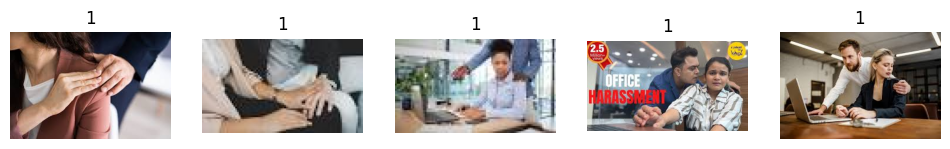

In [17]:
# Plot sample images
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1) #1 - row 5 -images i+1 - index
    img = load_img(train['image'][i])
    plt.imshow(img)
    plt.title(train['class'][i])
    plt.axis('off') #displays only the images
plt.show()

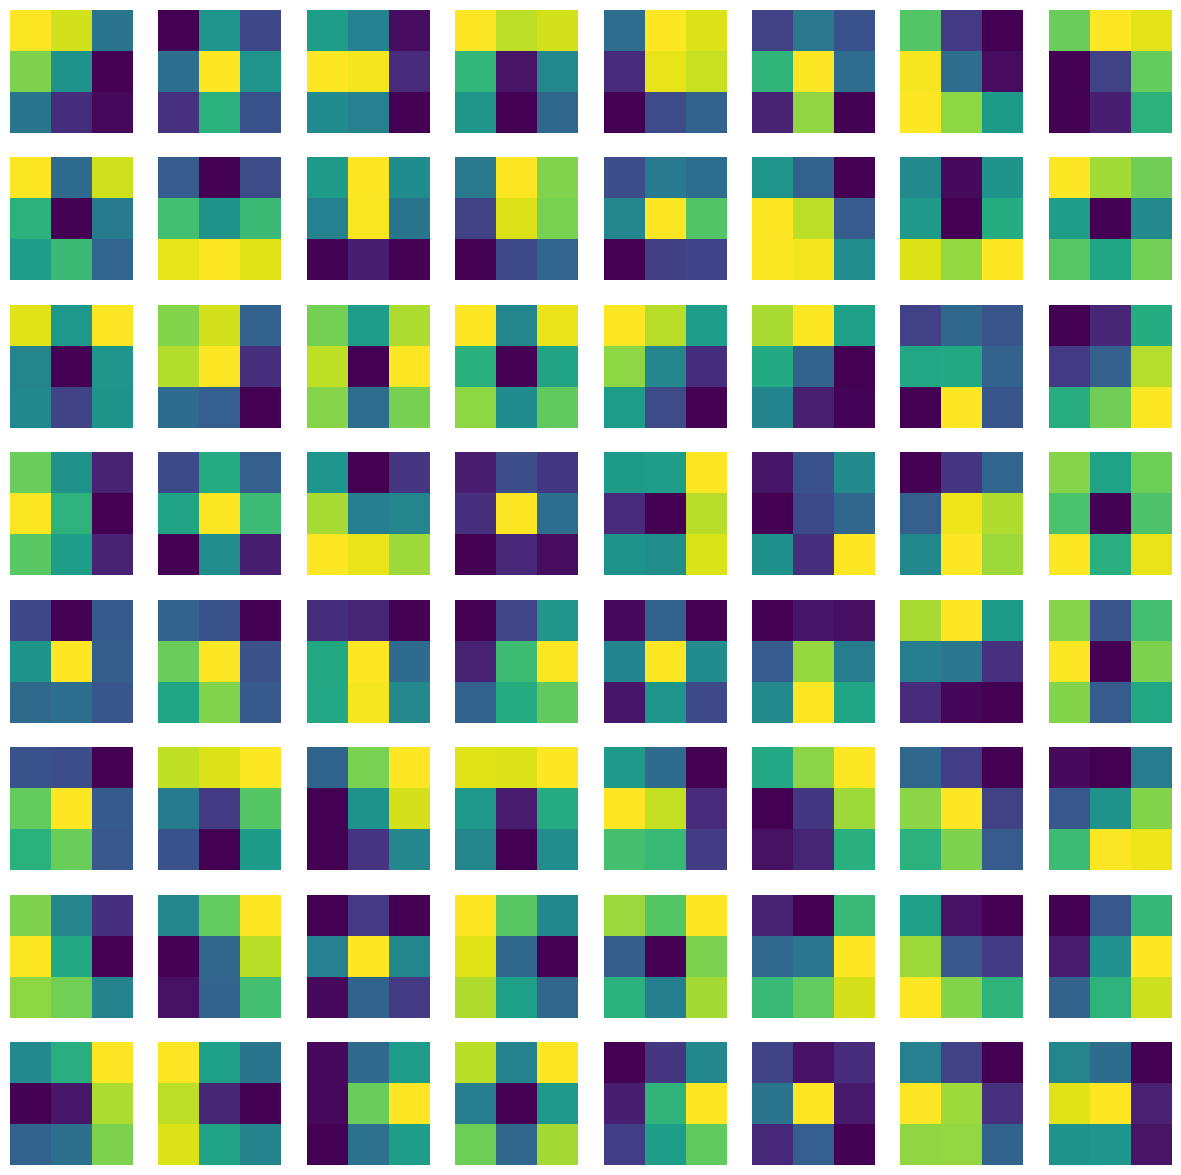

In [18]:
# Visualize filters in the first convolutional layer
filters = base_model.get_layer('block1_conv1').get_weights()[0] #retrieves the filters in the first convo layer 
plt.figure(figsize=(15, 15))
for i in range(filters.shape[-1]):
    plt.subplot(8, 8, i + 1) #size and index of subplots
    plt.imshow(filters[:, :, 0, i], cmap='viridis') #0-input channel
    plt.axis('off')
plt.show()
#helps to understand the types of features the filters are learning to detect in the input data.

(array([0, 1]), [Text(0, 0, '1'), Text(1, 0, '0')])

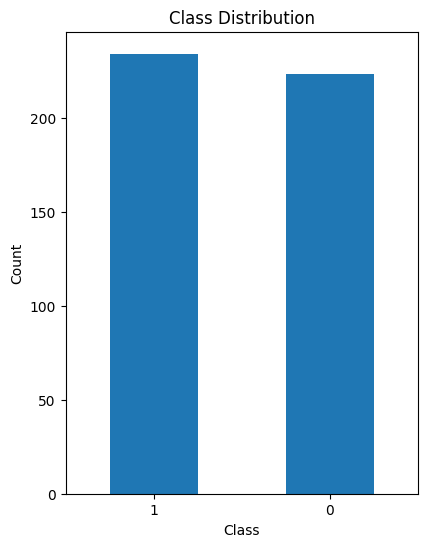

In [19]:
# Visualize class distribution
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1) #1-row 2-columns , 1st subplot
train['class'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')

plt.ylabel('Count')
plt.xticks(rotation=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


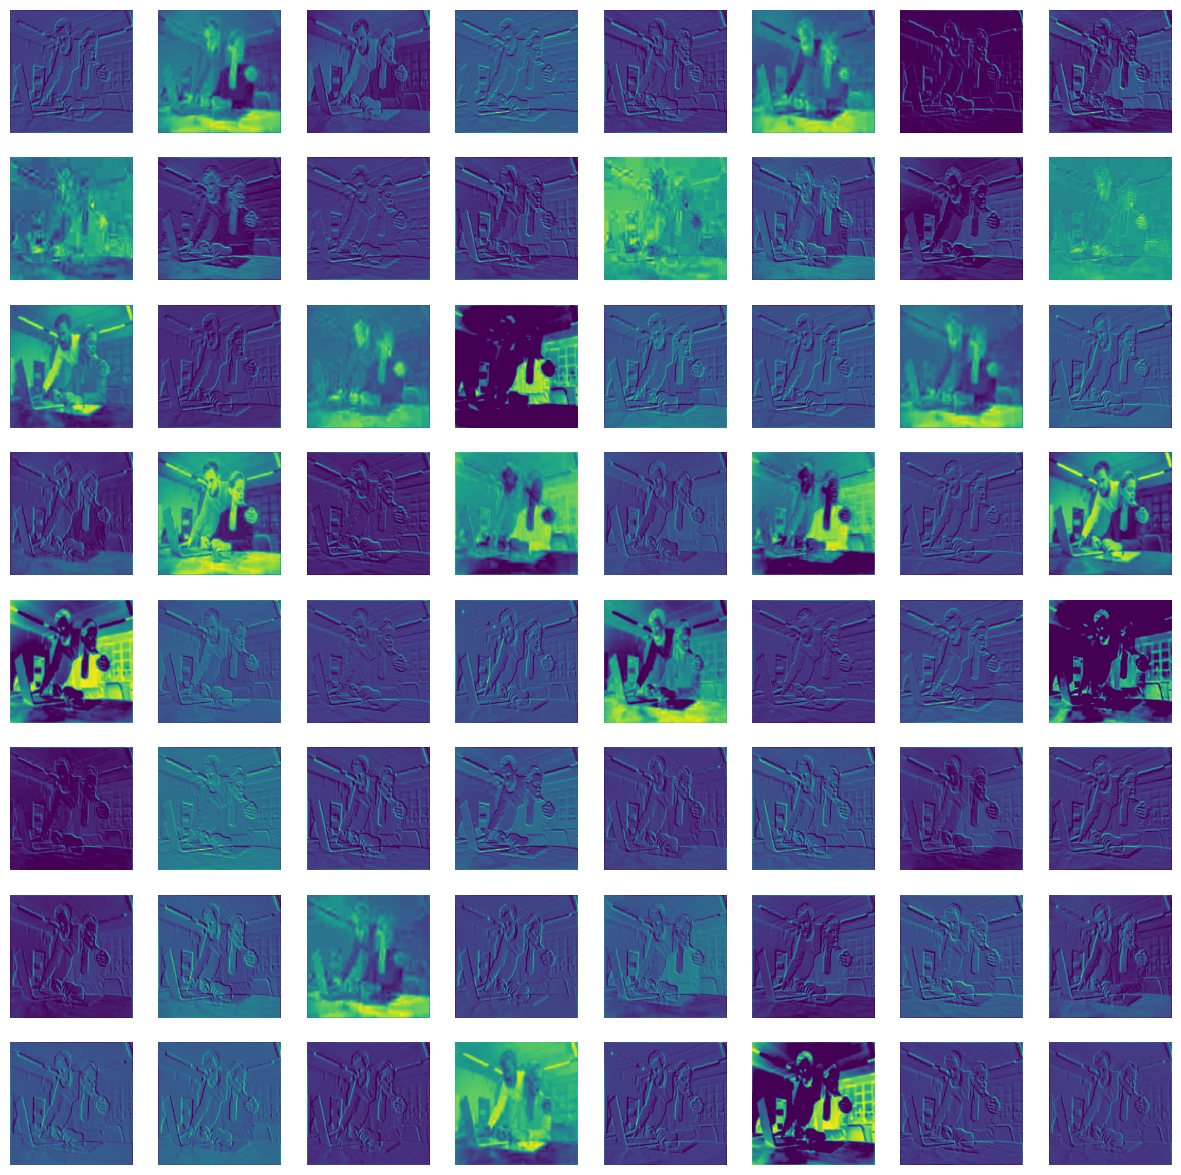

In [20]:
# Function to visualize filter evolution
img_path=r'C:\PEC-26\Intel Hackathon\Attempt-1\DATA\image\harrasment_yes\download.jpeg' 
img = load_img(img_path, target_size=(224, 224)) #loads the image in the specified path
img = img_to_array(img) #converts the image into a NumPy array
img = np.expand_dims(img, axis=0) #adds a new dimension
img /= 255.0 #normalization
    
intermediate_layer_model = keras.Model(inputs=base_model.input, outputs=base_model.get_layer('block1_conv1').output)
intermediate_output = intermediate_layer_model.predict(img)
    
plt.figure(figsize=(15, 15))
for i in range(intermediate_output.shape[-1]):
    plt.subplot(8, 8, i+1)
    plt.imshow(intermediate_output[0, :, :, i], cmap='viridis') #0 - selects the first sample in the batch
    plt.axis('off')
plt.show()

In [21]:
# Function to visualize t-SNE embeddings
def visualize_tsne(X, y):
    tsne = TSNE(n_components=2, random_state=42) #creates a new t-SNE object 
    X_tsne = tsne.fit_transform(X) #applies algorithm to feature data
    
    plt.figure(figsize=(8, 6)) #plot figure size
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap=plt.cm.Paired) #c - assigns colors based on target labels, cm- colormap
    plt.title("t-SNE Visualization")
    plt.show()

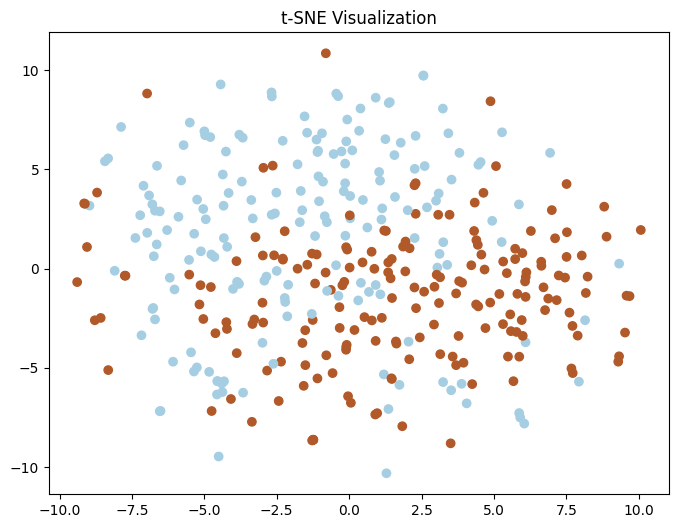

In [22]:
# Visualize t-SNE embeddings
visualize_tsne(x_train, y_train.values.argmax(axis=1)) 

In [23]:
# training the model
vgg_hist = model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test), callbacks=[mcp_save], batch_size=12)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 283ms/step - accuracy: 0.5468 - loss: 0.9655 - val_accuracy: 0.6848 - val_loss: 0.6743
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 289ms/step - accuracy: 0.4881 - loss: 0.9649 - val_accuracy: 0.6522 - val_loss: 0.6661
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 266ms/step - accuracy: 0.5194 - loss: 0.7831 - val_accuracy: 0.6848 - val_loss: 0.6503
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 275ms/step - accuracy: 0.5959 - loss: 0.6592 - val_accuracy: 0.8152 - val_loss: 0.5460
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 296ms/step - accuracy: 0.7362 - loss: 0.5300 - val_accuracy: 0.7717 - val_loss: 0.4471
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 241ms/step - accuracy: 0.8171 - loss: 0.3865 - val_accuracy: 0.7935 - val_loss: 0.4773
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 235ms/step - accuracy: 0.8441 - loss: 0.3282 - val_accuracy: 0.8043 - val_loss: 0.4490
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 235ms/step - accuracy: 0.9049 - loss: 0.2551 - val_acc

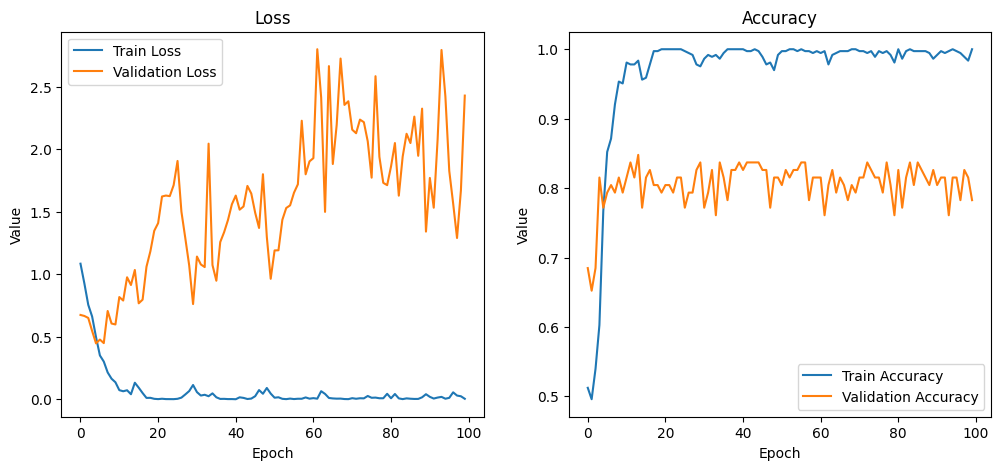

In [24]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(vgg_hist.history['loss'], label='Train Loss')
plt.plot(vgg_hist.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(vgg_hist.history['accuracy'], label='Train Accuracy')
plt.plot(vgg_hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/stepWARNING:tensorflow:5 out of the last 19 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002002DB2ECA0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


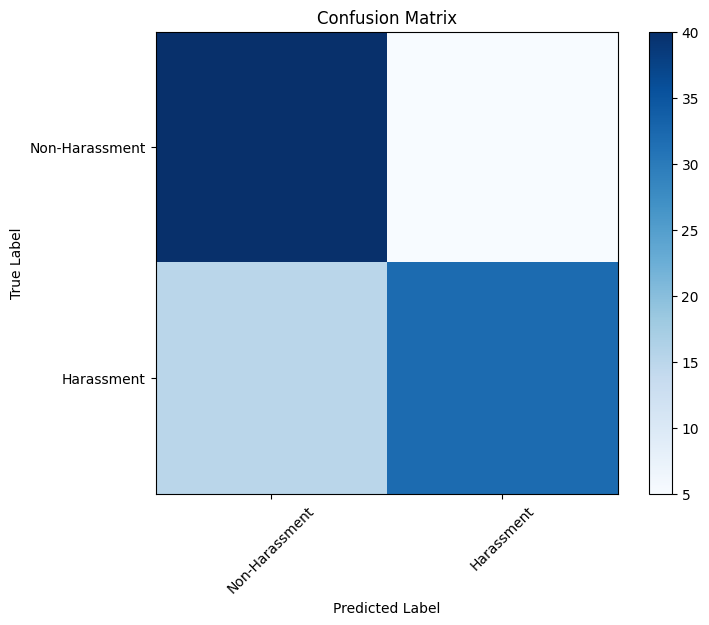

In [25]:
# Plot confusion matrix
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test.values, axis=1)
class_names = ['Non-Harassment', 'Harassment']
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [26]:
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7858 - loss: 2.1619
Test Accuracy: 78.2608687877655


In [28]:
# Load the trained model
from keras._tf_keras.keras.models import load_model
import numpy as np
from keras._tf_keras.keras.preprocessing import image
from keras._tf_keras.keras.preprocessing.image import load_img, img_to_array
from keras._tf_keras.keras.applications.vgg16 import VGG16, preprocess_input

In [29]:
model = load_model('weight.keras')  # Make sure you have the correct path to your saved model

In [30]:
# Example usage
image_path = "DATA/image/harrasment_no/images.jpeg"  # Replace with the path to any test image
img = image.load_img(image_path, target_size=(224, 224))
img = image.img_to_array(img)
img = img / 255.0
img = np.expand_dims(img, axis=0)  # Add batch dimension as the model expects it
new_image = img

In [31]:
# Extract features using the VGG16 base model
base_model = VGG16(weights='imagenet', include_top=False)
new_image_features = base_model.predict(new_image)

# Reshape the features
new_image_features = new_image_features.reshape(1, 7*7*512)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


In [32]:
# Make predictions
predictions = model.predict(new_image_features)

# Since your model has 2 output neurons (softmax), you can use argmax to get the predicted class index
predicted_class_index = np.argmax(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


In [39]:
# If your classes are labeled as 0 and 1, you can map the index back to class labels
class_labels = {0: 'Healthy Environment', 1: 'Sexual Harassment Detected'}
predicted_class_label = class_labels[predicted_class_index]
#print(type(predicted_class_label))
print("Predicted Class Label:", predicted_class_label)

Predicted Class Label: Healthy Environment


In [40]:
import cv2
import numpy as np
from keras.models import load_model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

In [41]:
# Load the trained model
model = load_model(r'weight.keras')  # Make sure you have the correct path to your saved model

In [42]:
# Load the VGG16 base model
base_model = VGG16(weights='imagenet', include_top=False)

In [43]:
# Preprocess a frame from the video
def preprocess_frame(frame):
    resized_frame = cv2.resize(frame, (224, 224))
    preprocessed_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)  # VGG16 expects RGB images
    preprocessed_frame = preprocess_input(preprocessed_frame)
    return preprocessed_frame

In [44]:
harrasment_frames = []

In [48]:
# Example usage
video_path = r"DATA/video/harrasment_yes/Domestic Violence {try not to remember}.mp4"  # Replace with the path to your video file

cap = cv2.VideoCapture(video_path)


while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess the frame
    preprocessed_frame = preprocess_frame(frame)

    # Extract features using the VGG16 base model
    new_image_features = base_model.predict(np.expand_dims(preprocessed_frame, axis=0))
    new_image_features = new_image_features.reshape(1, 7 * 7 * 512)

    # Make predictions
    predictions = model.predict(new_image_features)

    # Get the predicted class index
    predicted_class_index = np.argmax(predictions[0])

    #Collect the predicted images
    if predicted_class_index == 1:
        harrasment_frames.append(frame)
    # If your classes are labeled as 0 and 1, you can map the index back to class labels
    class_labels = {0: 'Healthy Environment', 1: 'Sexual Harassment Detected'}
    predicted_class_label = class_labels[predicted_class_index]
    color = (0, 255, 0) if predicted_class_label == "Healthy Environment" else (0, 0, 255)
    # Display the predicted class label on the frame
    cv2.putText(frame, predicted_class_label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, color=color, thickness=2)

    # Display the frame
    cv2.imshow("Video with Prediction", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

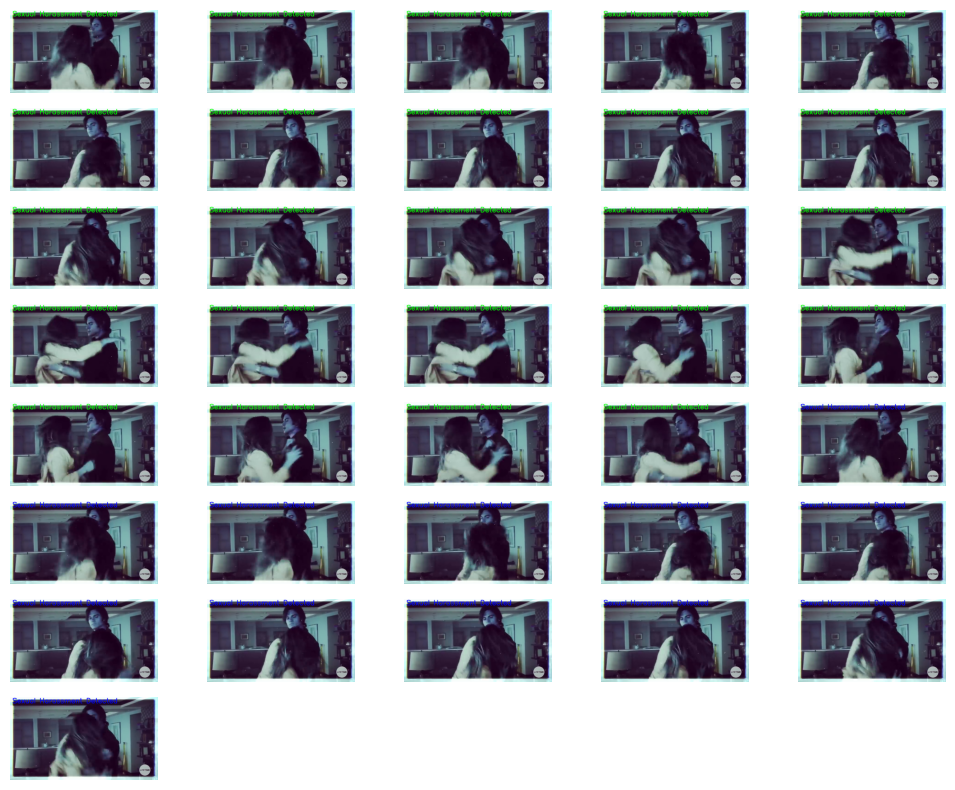

In [49]:
import math
# Plot harrasment images
num_images = len(harrasment_frames)
columns = 5  # Set how many images you want per row
rows = math.ceil(num_images / columns)  # Calculate how many rows are needed

plt.figure(figsize=(10, rows))  # Adjust the figure size based on the number of rows
for i in range(num_images):
    plt.subplot(rows, columns, i + 1)
    plt.imshow(harrasment_frames[i])
    plt.axis('off')  # Hides the axes

plt.tight_layout()  # Adjusts the spacing between images
plt.show()

In [50]:
output_dir = r'DATA\harrasment_detected'
for i in range(len(harrasment_frames)):
    frame_filename = f"{i}.jpg"
    frame_path = os.path.join(output_dir, frame_filename)
            
    cv2.imwrite(frame_path, harrasment_frames[i]) 

In [52]:
#saving our model
model.save('harrasment_model.keras')

In [55]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite",'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\THAMIZ~1\AppData\Local\Temp\tmpus_0z5qm\assets


INFO:tensorflow:Assets written to: C:\Users\THAMIZ~1\AppData\Local\Temp\tmpus_0z5qm\assets


Saved artifact at 'C:\Users\THAMIZ~1\AppData\Local\Temp\tmpus_0z5qm'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 25088), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  2199880011984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2199880012368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2199880011600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2199880013904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2199880011792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2199880015056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2199880013328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2199880016208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2199880016592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2199880017552: TensorSpec(shape=(), dtype=tf.resource, name=None)
